In [48]:
# ==============================================================================
# 0. SETUP, LIBRARY IMPORTS, AND GOOGLE DRIVE MOUNT
# ==============================================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, LSTM, GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from itertools import product
from IPython.display import display
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
sns.set_style("whitegrid")

# --- DATA PATH CONFIGURATION ---
data_path = "/content/drive/MyDrive/SWE/Year3Sem1/DAM_202/weather_data.csv"
sequence_length = 30 # Time Steps: Use 30 days of history to predict the next day

# --- MOUNT GOOGLE DRIVE ---
# This step is CRUCIAL for accessing the file path provided.
try:
    from google.colab import drive
    print("Attempting to mount Google Drive...")
    drive.mount('/content/drive')
    print("Google Drive mounted successfully.")
except ImportError:
    print("Running outside Google Colab. Ensure 'data_path' is accessible locally.")
except Exception as e:
    print(f"Error mounting Google Drive: {e}")
    print("Ensure you are running this code in a Google Colab notebook.")
# ==============================================================================


Attempting to mount Google Drive...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Google Drive mounted successfully.


In [49]:
# ==============================================================================
# 1. DATA PREPROCESSING PIPELINE (Includes Visualization)
# ==============================================================================

def load_weather_data(file_path):
    """Load and prepare weather data from the specified path."""
    try:
        df = pd.read_csv(file_path)
    except FileNotFoundError:
        print(f"ERROR: File not found at {file_path}. Please check the path and if Google Drive is mounted.")
        # Create dummy data to prevent immediate crash, but pipeline will be inaccurate
        raise

    if df.shape[1] >= 7:
        columns = ['Year', 'Day', 'Wind_Speed', 'Specific_Humidity',
                   'Relative_Humidity', 'Precipitation', 'Temperature']
        df.columns = columns

    df['Date'] = pd.to_datetime(df['Year'].astype(str) + '-' + df['Day'].astype(str), format='%Y-%j')
    df.set_index('Date', inplace=True)
    df.drop(['Year', 'Day'], axis=1, inplace=True)
    return df

def explore_data(df):
    """Comprehensive data exploration including time series plots (Visualization)"""
    print("\n--- Data Exploration ---")
    print("Dataset Shape:", df.shape)
    print("Statistical Summary:\n", df.describe())
    print("Missing Values:\n", df.isnull().sum())

    # Plot time series for all features (Visualization)
    print("\n--- Time Series Plots (Data Visualization) ---")
    fig, axes = plt.subplots(len(df.columns), 1, figsize=(15, 3*len(df.columns)))

    # Use a fixed number of steps (e.g., 5 years) for a clear plot sample
    sample_steps = min(len(df), 365 * 5)
    sample_df = df.head(sample_steps)

    for i, col in enumerate(df.columns):
        axes[i].plot(sample_df.index, sample_df[col])
        axes[i].set_title(f'{col} Over Time (Sample: First {sample_steps} Days)', fontsize=14)
        axes[i].set_ylabel(col)
    plt.tight_layout()
    plt.show()

def get_season(month):
    """Convert month to season"""
    if month in [12, 1, 2]: return 0
    elif month in [3, 4, 5]: return 1
    elif month in [6, 7, 8]: return 2
    else: return 3

def clean_and_engineer_features(df):
    """Advanced preprocessing and feature engineering"""
    df = df.fillna(method='ffill').fillna(method='bfill').interpolate(method='linear')

    df['Day_of_Year'] = df.index.dayofyear
    df['Month'] = df.index.month
    df['Season'] = df['Month'].apply(get_season)
    df['Day_sin'] = np.sin(2 * np.pi * df['Day_of_Year'] / 365.25)
    df['Day_cos'] = np.cos(2 * np.pi * df['Day_of_Year'] / 365.25)

    # Moving averages and Lag features
    for col in ['Temperature', 'Wind_Speed', 'Relative_Humidity']:
        df[f'{col}_MA_7'] = df[col].rolling(window=7).mean().shift(1)
    for lag in [1, 7, 30]:
        df[f'Temp_lag_{lag}'] = df['Temperature'].shift(lag)

    df.drop(['Day_of_Year', 'Month', 'Season'], axis=1, inplace=True)
    df.dropna(inplace=True)
    return df

def create_train_test_split(df, test_size=0.2, val_size=0.1):
    """Time series aware train-test split (No shuffling)"""
    n = len(df)
    train_end = int(n * (1 - test_size - val_size))
    val_end = int(n * (1 - test_size))
    train_data = df.iloc[:train_end]
    val_data = df.iloc[train_end:val_end]
    test_data = df.iloc[val_end:]
    return train_data, val_data, test_data

def normalize_data(df, feature_columns, target_column, feature_scaler, target_scaler):
    """Normalize data using provided scalers."""
    features_scaled = feature_scaler.transform(df[feature_columns])
    target_scaled = target_scaler.transform(df[[target_column]])
    return features_scaled, target_scaled


--- Data Exploration ---
Dataset Shape: (12113, 5)
Statistical Summary:
          Wind_Speed  Specific_Humidity  Relative_Humidity  Precipitation  \
count  12113.000000       12113.000000       12113.000000   12113.000000   
mean       1.311912          15.207111          74.635416       7.183984   
std        0.539321           5.529803          15.286193      13.126254   
min        0.440000           2.620000          15.810000       0.000000   
25%        0.950000           9.950000          65.250000       0.000000   
50%        1.150000          16.170000          79.620000       1.160000   
75%        1.520000          20.570000          86.560000       9.260000   
max        5.340000          24.290000          96.120000     170.630000   

        Temperature  
count  12113.000000  
mean      25.038147  
std        4.373427  
min       11.190000  
25%       21.430000  
50%       26.930000  
75%       28.400000  
max       35.490000  
Missing Values:
 Wind_Speed           0
Spe

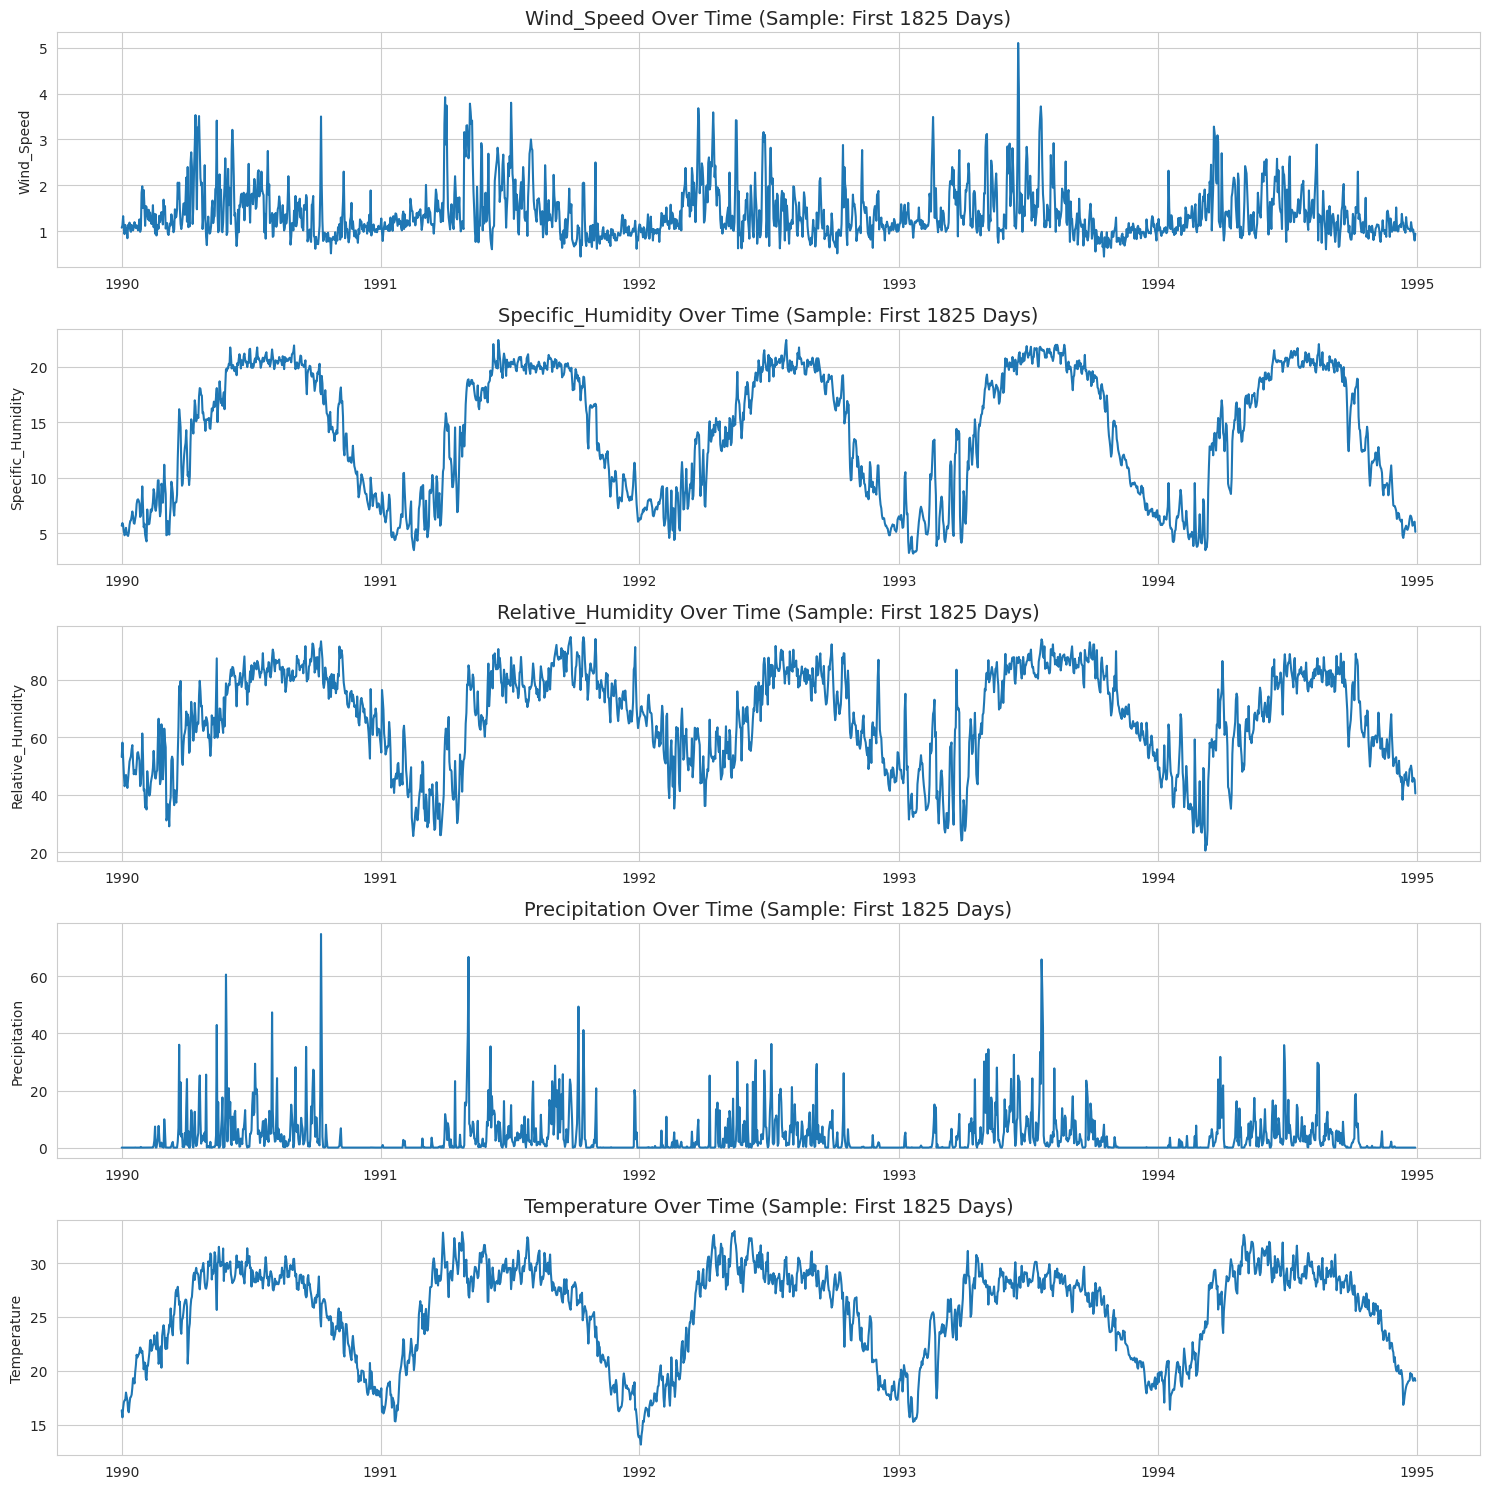

In [50]:
df_raw = load_weather_data(data_path)
explore_data(df_raw)

In [51]:
# ==============================================================================
# 2. SEQUENCE CREATION (TIME STEPS)
# ==============================================================================

def create_sequences(data, target, sequence_length, prediction_horizon=1):
    """Transforms data into RNN sequences (X) and targets (y)"""
    X, y = [], []
    for i in range(sequence_length, len(data) - prediction_horizon + 1):
        X.append(data[i-sequence_length:i])
        y.append(target[i:i+prediction_horizon])
    return np.array(X), np.array(y)

def prepare_sequences(train_data, val_data, test_data, feature_columns,
                     target_column, sequence_length, prediction_horizon,
                     feature_scaler, target_scaler):
    """Applies scaling and creates sequences for all splits"""

    # Transform data using already fitted scalers
    train_features_scaled = feature_scaler.transform(train_data[feature_columns])
    train_target_scaled = target_scaler.transform(train_data[[target_column]])

    val_features_scaled = feature_scaler.transform(val_data[feature_columns])
    val_target_scaled = target_scaler.transform(val_data[[target_column]])
    test_features_scaled = feature_scaler.transform(test_data[feature_columns])
    test_target_scaled = target_scaler.transform(test_data[[target_column]])


    # Create sequences (Sequence Length/Time Steps is applied here)
    X_train, y_train = create_sequences(train_features_scaled, train_target_scaled.flatten(),
                                       sequence_length, prediction_horizon)
    X_val, y_val = create_sequences(val_features_scaled, val_target_scaled.flatten(),
                                   sequence_length, prediction_horizon)
    X_test, y_test = create_sequences(test_features_scaled, test_target_scaled.flatten(),
                                     sequence_length, prediction_horizon)

    # Reshape targets back to (samples, 1) if prediction_horizon is 1
    if prediction_horizon == 1:
        y_train, y_val, y_test = y_train.reshape(-1, 1), y_val.reshape(-1, 1), y_test.reshape(-1, 1)


    return (X_train, y_train), (X_val, y_val), (X_test, y_test)

In [52]:
# ==============================================================================
# 3. MODEL ARCHITECTURE, TRAINING, AND HYPERPARAMETER TUNING
# ==============================================================================

# Dictionary to store results for comparison
model_results = {}
history_dict = {}

def build_rnn_model(input_shape, model_type='LSTM', hidden_units=[64, 32],
                    dropout_rate=0.2, learning_rate=0.001, prediction_horizon=1):
    """
    Builds the RNN, LSTM, or GRU model architecture with Dropout regularization.
    """
    model = Sequential(name=f"Weather_Prediction_{model_type}")
    model.add(tf.keras.layers.Input(shape=input_shape))

    for i, units in enumerate(hidden_units):
        # return_sequences=True for all but the last recurrent layer
        return_sequences = i < len(hidden_units) - 1

        if model_type == 'LSTM':
            model.add(LSTM(units, return_sequences=return_sequences,
                           dropout=dropout_rate, name=f'LSTM_Layer_{i+1}'))
        elif model_type == 'GRU':
            model.add(GRU(units, return_sequences=return_sequences,
                          dropout=dropout_rate, name=f'GRU_Layer_{i+1}'))
        else:
            model.add(SimpleRNN(units, return_sequences=return_sequences,
                                dropout=dropout_rate, name=f'RNN_Layer_{i+1}'))

    model.add(Dense(prediction_horizon, activation='linear', name='Output_Layer'))

    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model

def train_and_compare_model(model_name, X_train, y_train, X_val, y_val, X_test, y_test, target_scaler, input_shape):
    """Trains, evaluates, and stores results for a specific model."""

    hyperparams = {
        'hidden_units': [64, 32],
        'dropout_rate': 0.2, # Hyperparameter Tuning
        'learning_rate': 0.001,
        'batch_size': 32,
        'epochs': 100
    }

    print(f"\n--- Training {model_name} Model ---")

    # Early Stopping (Hyperparameter Tuning/Regularization)
    early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=0)

    # ReduceLROnPlateau can also be added here for advanced tuning
    # reduce_lr = ReduceLROnPlateau(factor=0.2, patience=8, min_lr=1e-7, monitor='val_loss')
    callbacks = [early_stopping]

    model = build_rnn_model(
        input_shape,
        model_type=model_name,
        hidden_units=hyperparams['hidden_units'],
        dropout_rate=hyperparams['dropout_rate'],
        learning_rate=hyperparams['learning_rate']
    )

    # Train the model
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=hyperparams['epochs'],
        batch_size=hyperparams['batch_size'],
        callbacks=callbacks,
        verbose=1 # Changed verbose to 1 to show training progress
    )
    history_dict[model_name] = history

    # Evaluate and Predict (Actual Weather Prediction)
    test_loss, test_mae = model.evaluate(X_test, y_test, verbose=0)
    y_pred_scaled = model.predict(X_test, verbose=0)

    # Inverse Transform to original scale
    y_pred_original = target_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
    y_test_original = target_scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

    # Calculate Evaluation Metrics (RMSE, MAE, R2)
    rmse = np.sqrt(mean_squared_error(y_test_original, y_pred_original))
    r2 = r2_score(y_test_original, y_pred_original)

    print(f"Test Loss (MSE): {test_loss:.6f} | RMSE: {rmse:.4f} | R2: {r2:.4f}")

    # Store results
    model_results[model_name] = {
        'Test Loss (MSE)': test_loss,
        'RMSE': rmse,
        'MAE': test_mae,
        'R2 Score': r2,
        'Predictions': y_pred_original
    }
    return model, history

In [53]:
# --- EXECUTION: PREPROCESSING AND SPLIT ---
print("\n--- Starting Step 2: Preprocessing and Split ---")
df_processed = clean_and_engineer_features(df_raw.copy())

# Split the data
train_data, val_data, test_data = create_train_test_split(df_processed)

print(f"Data ready for scaling (Shape: {df_processed.shape})")
print(f"Train Set Size: {train_data.shape[0]}")
print(f"Validation Set Size: {val_data.shape[0]}")
print(f"Test Set Size: {test_data.shape[0]}")


--- Starting Step 2: Preprocessing and Split ---
Data ready for scaling (Shape: (12083, 13))
Train Set Size: 8458
Validation Set Size: 1208
Test Set Size: 2417


In [54]:
# ==============================================================================
# 4. MODEL EVALUATION AND COMPARISON (Visualization)
# ==============================================================================

def plot_learning_curves(history, model_name):
    """Plots the training and validation loss over epochs (Learning Curves Analysis)"""
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} Learning Curve (Loss vs. Epoch)')
    plt.ylabel('Loss (MSE)')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_predictions(y_true, y_pred, model_name, plot_steps=100):
    """Plots a segment of the actual vs. predicted values (Actual Weather Prediction Visualization)"""
    plt.figure(figsize=(14, 6))
    plt.plot(y_true[:plot_steps], label='Actual Temperature', color='blue')
    plt.plot(y_pred[:plot_steps], label=f'{model_name} Predicted Temperature', color='red', linestyle='--')
    plt.title(f'{model_name} Actual vs. Predicted Weather (First {plot_steps} Test Steps)')
    plt.ylabel('Temperature (°C)')
    plt.xlabel('Time Step')
    plt.legend()
    plt.grid(True)
    plt.show()

def generate_comparison_table():
    """Generates the final comparison table (Rubrics Requirement)"""
    comparison_df = pd.DataFrame(model_results).T[['Test Loss (MSE)', 'RMSE', 'MAE', 'R2 Score']]

    print("\n--- Model Performance Comparison Table ---")
    # Highlight the best performance (min for errors, max for R2)
    styled_comparison_df = comparison_df.style.highlight_min(
        subset=['Test Loss (MSE)', 'RMSE', 'MAE'], color='#d4edda' # Light Green
    ).highlight_max(
        subset=['R2 Score'], color='#d4edda'
    ).format({
        'Test Loss (MSE)': '{:.6f}',
        'RMSE': '{:.4f}',
        'MAE': '{:.4f}',
        'R2 Score': '{:.4f}'
    })

    display(styled_comparison_df)


In [55]:
# --- EXECUTION: SCALING AND SEQUENCE CREATION ---
print("\n--- Starting Step 3: Scaling and Sequence Creation ---")

# Initialize a dictionary to store global results
global_results = {}

# Define target column and feature columns
target_column = 'Temperature'
feature_columns = [col for col in df_processed.columns if col != target_column]

# Initialize and fit scalers on training data (to prevent data leakage)
feature_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()

feature_scaler.fit(train_data[feature_columns])
target_scaler.fit(train_data[[target_column]])

global_results['target_scaler'] = target_scaler

# Create sequences (Time Steps)
(X_train, y_train), (X_val, y_val), (X_test, y_test) = prepare_sequences(
    train_data, val_data, test_data, feature_columns, target_column, sequence_length, prediction_horizon=1, feature_scaler=feature_scaler, target_scaler=target_scaler
)

# Store test data globally for plotting later
global_results['X_test'] = X_test
global_results['y_test'] = y_test

print(f"RNN Input Shape (Samples, Time Steps, Features): {X_train.shape}")
print(f"Sequence Length (Time Steps) used: {sequence_length}")
print("Sequences created successfully.")


--- Starting Step 3: Scaling and Sequence Creation ---
RNN Input Shape (Samples, Time Steps, Features): (8428, 30, 12)
Sequence Length (Time Steps) used: 30
Sequences created successfully.


In [56]:
# --- EXECUTION: MODEL TRAINING AND EVALUATION ---
print("\n--- Starting Step 4: Model Training and Evaluation ---")

# Get input shape for Keras models
input_shape = (X_train.shape[1], X_train.shape[2])
models_to_run = ['SimpleRNN', 'LSTM', 'GRU']

for model_name in models_to_run:
    train_and_compare_model(
        model_name, X_train, y_train, X_val, y_val, X_test, y_test,
        global_results['target_scaler'], input_shape
    )
print("\nModel training and evaluation complete.")


--- Starting Step 4: Model Training and Evaluation ---

--- Training SimpleRNN Model ---
Epoch 1/100
264/264 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.1427 - mae: 0.2311 - val_loss: 0.0042 - val_mae: 0.0497
Epoch 2/100
264/264 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0127 - mae: 0.0879 - val_loss: 0.0041 - val_mae: 0.0509
Epoch 3/100
264/264 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0086 - mae: 0.0711 - val_loss: 0.0065 - val_mae: 0.0661
Epoch 4/100
264/264 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0069 - mae: 0.0642 - val_loss: 0.0049 - val_mae: 0.0549
Epoch 5/100
264/264 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0066 - mae: 0.0625 - val_loss: 0.0038 - val_mae: 0.0482
Epoch 6/100
264/264 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0055 - mae: 0.0571 - val_loss: 0.0066 - val_mae: 0.0663
Epoch 7/100
264/264 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0050 - mae: 0.0540 - val_loss: 0.0072 - val_mae: 0.0712
Epoch 8/100
264/264 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0045 - mae: 


--- Starting Step 5: Model Evaluation and Comparison ---

--- Plotting Learning Curves ---


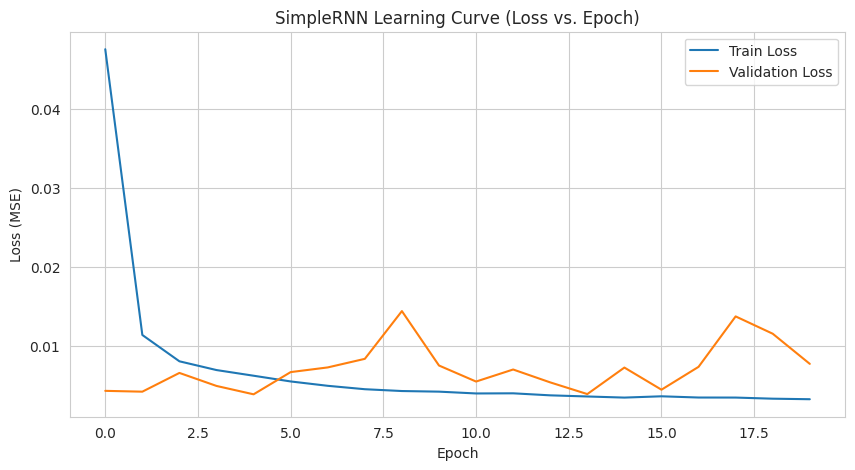

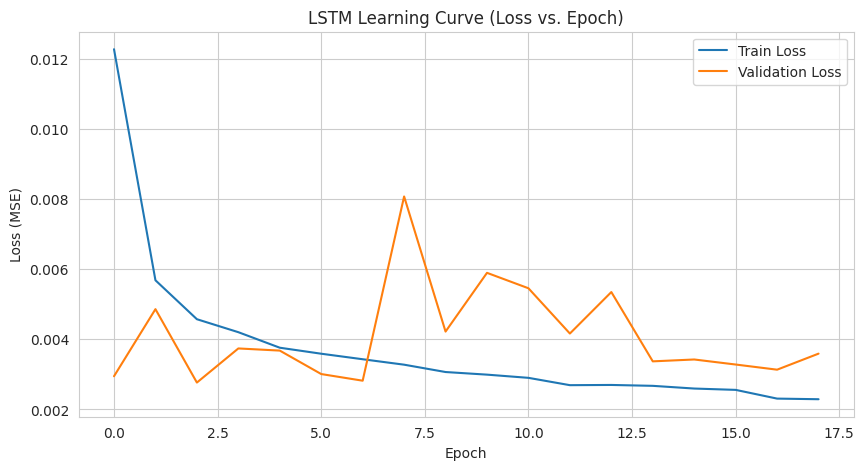

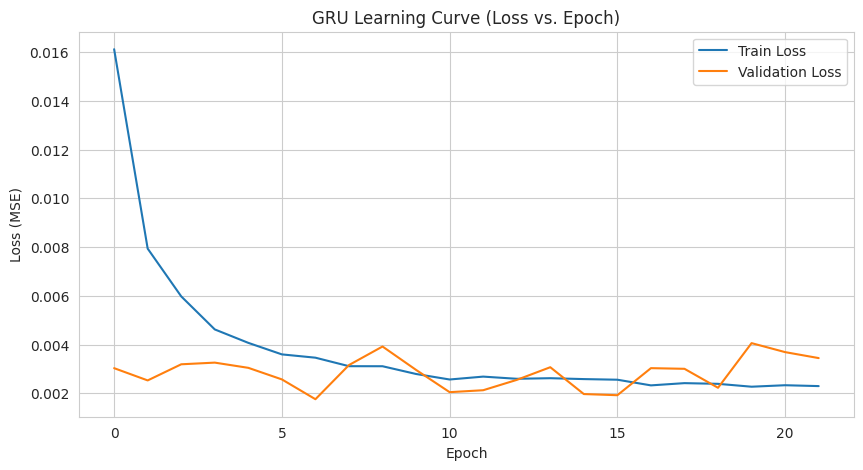

In [57]:
# --- EXECUTION: MODEL EVALUATION AND COMPARISON (Visualization) ---
print("\n--- Starting Step 5: Model Evaluation and Comparison ---")

# Plot learning curves for each model
print("\n--- Plotting Learning Curves ---")
if 'SimpleRNN' in history_dict:
    plot_learning_curves(history_dict['SimpleRNN'], 'SimpleRNN')
if 'LSTM' in history_dict:
    plot_learning_curves(history_dict['LSTM'], 'LSTM')
if 'GRU' in history_dict:
    plot_learning_curves(history_dict['GRU'], 'GRU')



--- Plotting Predictions vs Actual ---


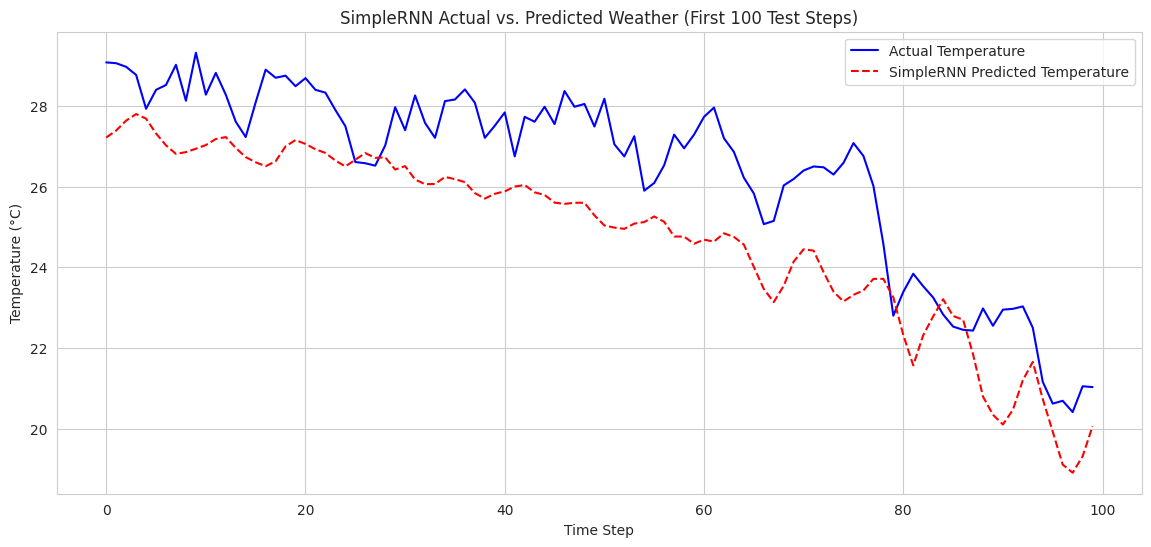

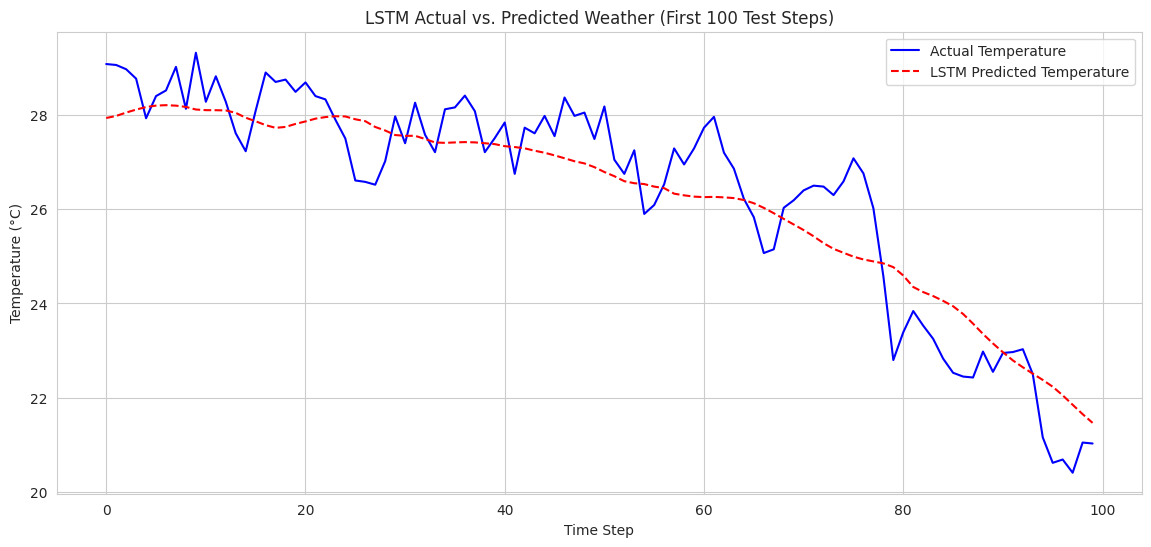

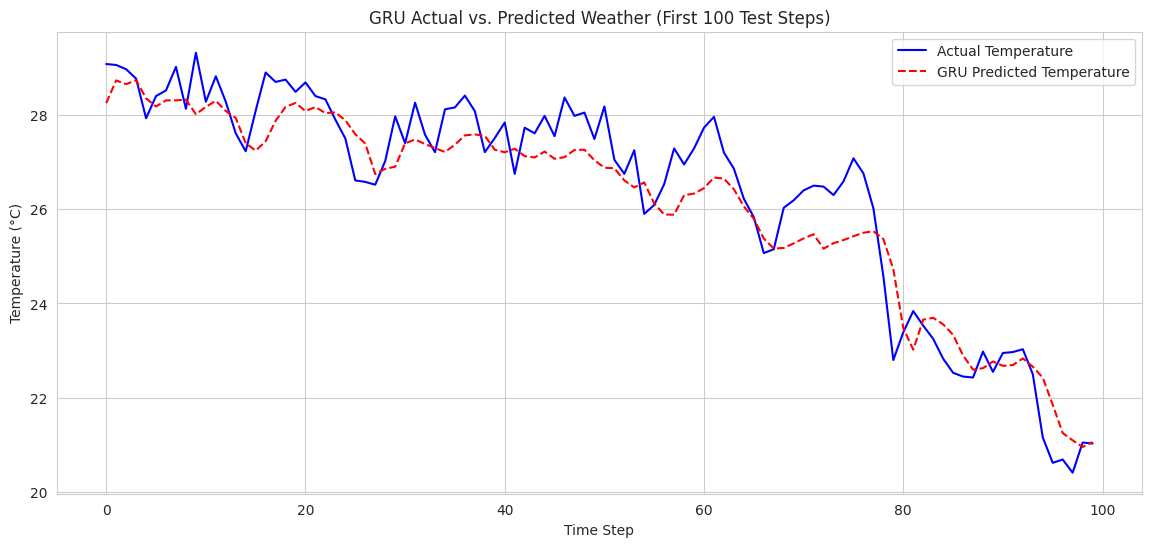

In [58]:
# Predictions vs actual for each model
print("\n--- Plotting Predictions vs Actual ---")
# Need original y_test data for plotting, inverse transform the scaled y_test
y_test_original = global_results['target_scaler'].inverse_transform(global_results['y_test'].reshape(-1, 1)).flatten()

if 'SimpleRNN' in model_results:
    plot_predictions(y_test_original, model_results['SimpleRNN']['Predictions'], 'SimpleRNN')
if 'LSTM' in model_results:
    plot_predictions(y_test_original, model_results['LSTM']['Predictions'], 'LSTM')
if 'GRU' in model_results:
    plot_predictions(y_test_original, model_results['GRU']['Predictions'], 'GRU')


In [59]:
# Comparison table
generate_comparison_table()

print("\n--- Model Evaluation and Comparison Complete ---")


--- Model Performance Comparison Table ---


,Test Loss (MSE),RMSE,MAE,R2 Score
SimpleRNN,0.004010,1.5388,0.0505,0.8708
LSTM,0.003784,1.4948,0.0452,0.8781
GRU,0.002206,1.1413,0.0353,0.9289



--- Model Evaluation and Comparison Complete ---
